# 03 - Interfaces, Nodes, and Workflows

#### Questions

- What are Nipype interfaces, nodes and workflows?
- Why bother using them?

#### Objective

- Setting up interface nodes
- Connecting different interfaces with each other

## Install fsl

In this notebook we use tools of the [FSL Software Library](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki).

### debian-based systems
```bash
sudo apt-get remove -y --purge man-db
apt-get update
apt-get install neurodebian-archive-keyring
add-apt-repository "deb http://neuro.debian.net/debian bionic main contrib non-free"
apt-get install fsl-core
```

### arch-based systems
```bash
yay -Syy fsl
```

In [20]:
import jupyter_black

jupyter_black.load()

In [21]:
import os


fslpath = "/usr/local/fsl"
project_root_dir = os.getcwd()
os.environ["FSLOUTPUTTYPE"] = "NIFTI"
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, "bin")

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

#!. ${FSLDIR}/etc/fslconf/fsl.sh
#!export FSLDIR PATH

In this notebook, we will use [NYU Slow Flanker dataset](https://openneuro.org/datasets/ds000102/versions/00001) from Openneuro. In this study, healthy adults underwent MRI scanning while performing an event-related [Eriksen Flanker task](https://en.wikipedia.org/wiki/Eriksen_flanker_task).

Running the cell below will download the first three subjects of the dataset. The data will be stored in ```/data```.

## Define parameters

As always, we start with defining some parameters, such as the data and output directory. Also, we will create a variable pointing to anatomical image of the first subject.

<div class="alert alert-warning">Make that file ds000102.zip is downloaded from gdrive and moved to below directory</div>

In [2]:
data_dir = project_root_dir + "/data/ds000102"
output_dir = "output"

test_subj = "sub-01"
test_anat = f"{data_dir}/{test_subj}/anat/{test_subj}_T1w.nii.gz"

## Nipype Interfaces

Last week we converted some DICOMS to NIfTI files using the Nipype interface of ```dcm2niix```. Now we will have a look at further interfaces and will learn how to connect them.

To recap: interfaces are wrappers that allow Nipype to run programs that are written in programming languages other than Python. For example, we can access the tools of the FSL software library within Python. Let's have a look at an example:

In [3]:
#
#
#

### Brain extraction using FSL's ```BET```

Besides the brain, raw MRI images contain non-brain tissue, i.e., skin, muscles, eye balls etc. These non-brain tissues may complicate some automated preprocessing steps such as [brain image segmentation](https://andysbrainbook.readthedocs.io/en/latest/SPM/SPM_Short_Course/SPM_04_Preprocessing/04_SPM_Segmentation.html). Thus, the so called [brain extraction](https://andysbrainbook.readthedocs.io/en/latest/fMRI_Short_Course/Preprocessing/Skull_Stripping.html) or skullstripping is often included as a preliminary step in the preprocessing pipeline, improving speed and accuracy of image segmentation.

To perform skullstripping, FSL offers the [BET (Brain Extraction Tool)](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET) which which we will access through its corresponding Nipype interface:

In [4]:
from nipype.interfaces.fsl import BET

# BET.help()

Analogous to using the ```dcm2niix``` interface in last week's notebook, we will create an interface object. However, this time we will directly provide the parameters. 

(Note from the ```BET.help()``` output above that ```in_file``` is the only mandatory parameter, but here we also want to define the location of the output file (default is the current working directory) and tell nipype to create a [brain mask](http://andysbrainblog.blogspot.com/2012/11/a-note-of-fmri-masks.html) as well) 

In [5]:
strip_skull = BET(in_file = test_anat,
                  out_file = f"{output_dir}/{test_subj}_T1w_bet.nii",
                  mask = True)

Now let's run the ```BET``` interface:

In [6]:
result_bet = strip_skull.run()

After running ```BET```, we can have a look at the created output files by calling the ```outputs``` argument of the ``BET`` object:

In [8]:
print(result_bet.outputs)


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/user/data/psy_misc/tewa2-neuroimaging/output/sub-01_T1w_bet_mask.nii
meshfile = <undefined>
out_file = /home/user/data/psy_misc/tewa2-neuroimaging/output/sub-01_T1w_bet.nii
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>



We can use the paths from the ```outputs``` argument to easily access the respective files and plot them:

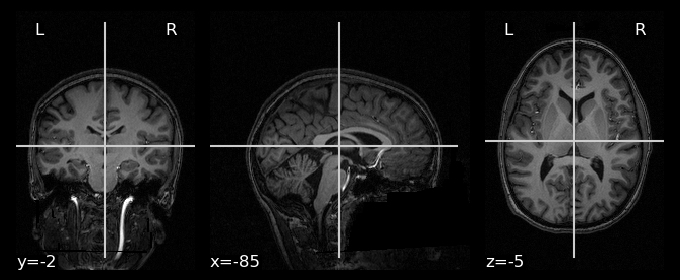

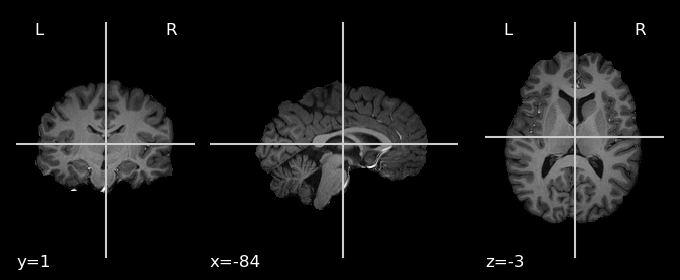

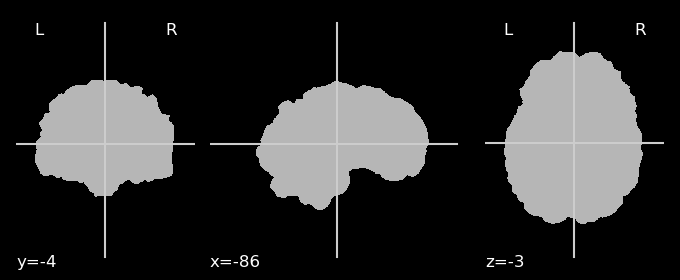

In [9]:
from nilearn import plotting

plotting.plot_anat(test_anat, dim=-1)                                           # set dim=-1 to increase contrast
plotting.plot_anat(result_bet.outputs.out_file, dim=-1)
plotting.plot_anat(result_bet.outputs.mask_file)

## instead of using the outputs argument we can also directly provide the respective path:
# plotting.plot_anat("output/sub-01_T1w_bet.nii")

Nilearn's plotting module also allows us to outline the brain mask on top of the non-skullstripped anatomical image. This is useful to determine how well the brain extraction worked.

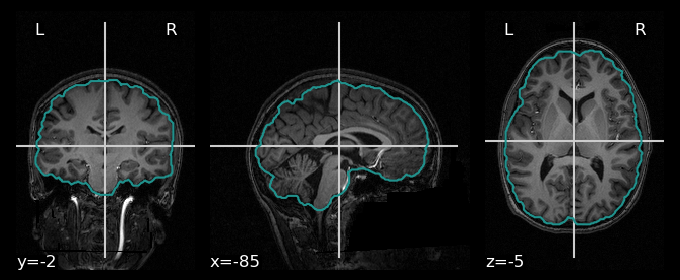

In [10]:
disp_anat = plotting.plot_anat(test_anat, dim=-1)
disp_anat.add_contours(result_bet.outputs.mask_file, levels=[0.5])

### Brain segmentation using FSL's ```FAST```

Put simply, [segmentation](https://andysbrainbook.readthedocs.io/en/latest/SPM/SPM_Short_Course/SPM_04_Preprocessing/04_SPM_Segmentation.html) is all about learning which voxels belong to which tissue type (i.e., grey matter, white matter and cerebrosplinal fluid (CSF)). This information can aid further steps down the preprocessing pipeline such as normalizing the image to and standard space.

Various neuroimaging software suites provide functionalities to perform segmentation. Here, we will use FSL's [```FAST```](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST) tool as we have FSL already installed.

In [11]:
from nipype.interfaces.fsl import FAST

#FAST.help()

Before setting up and running the inferface, however, we will have a look at some fundamental concepts of Nipype: Nodes and Workflows.

## Nipype Nodes and Workflows

As mentioned earlier, segmentation can be improved when we remove any non-brain tissue beforehand. Thus, we would use the output from the ```BET``` interface (i.e., the extracted brain image) as the input for the segmentation interface. Such process can be streamlined by using Nipype's Nodes and Worklows. These utilites make up the main benefits of Nipype. To quote from the [official Nipype tutorial](https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html):

> A workflow controls the setup and the execution of individual interfaces. Let's assume you want to run multiple interfaces in a specific order, where some have to wait for others to finish while others can be executed in parallel. The nice thing about a nipype workflow is, that the workflow will take care of input and output of each interface and arrange the execution of each interface in the most efficient way.

>A workflow therefore consists of multiple Nodes, each representing a specific Interface and directed connection between those nodes. Those connections specify which output of which node should be used as an input for another node.

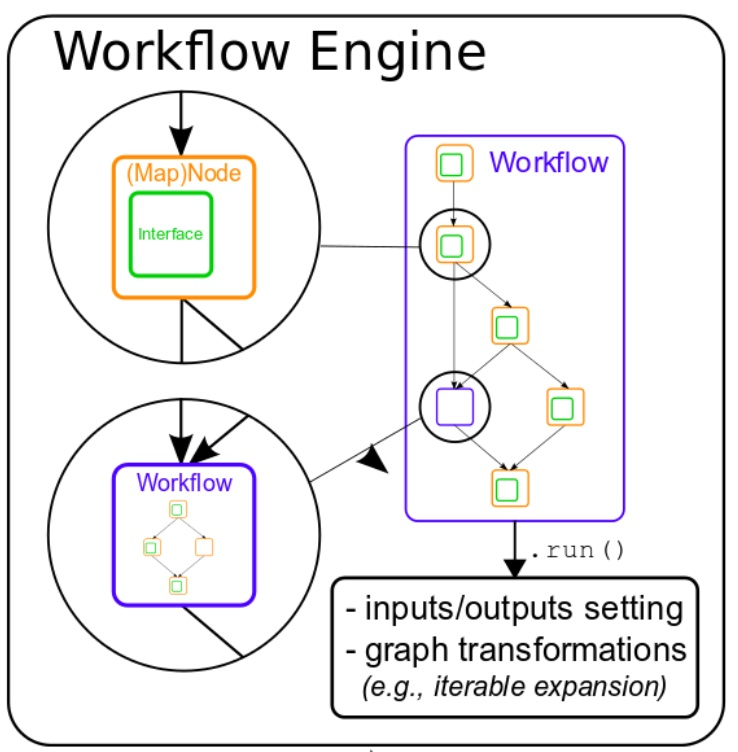

Alright, let's setup Nodes for the ```BET``` and ```FAST```interfaces. The general form of a node looks as follows:

```nodename = Nodetype(interface_function(), name='labelname')```

In [13]:
from nipype import Node, Workflow

# Skullstrip Node
strip_skull = Node(BET(in_file=test_anat,
                           mask=True),
                   name = "strip_skull")

# Segmentation Node
segment     = Node(FAST(),
                   name = "segment")

We have now created the respective nodes (note that nothing has been executed yet). The next step is to initialize a Workflow object:

In [14]:
# Initialize workflow
wf = Workflow(name = "test_workflow",
              base_dir = "output/working_dir")

The next step is to connect our nodes to each other. This can be done by calling the Workflow object's (```wf```) method ```connect```. The basic syntax looks like this:

```
connect([(source, dest, [("source_output1", "dest_input1"),
                         ("source_output2", "dest_input2")
                         ])
        ])
```

If you are unsure how the input and output files are named in the respective interfaces, you can always check it by using the ```help()``` method of the respective object.

In [15]:
# Connect nodes
wf.connect([(strip_skull, segment, [("out_file", "in_files")])])

Nipype also comes with a tool to visualize the workflow we have just created. This is handy to make sure that everything has been setup correctly:

221108-14:18:03,459 nipype.workflow INFO:
	 Generated workflow graph: /home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/graph.png (graph2use=flat, simple_form=True).


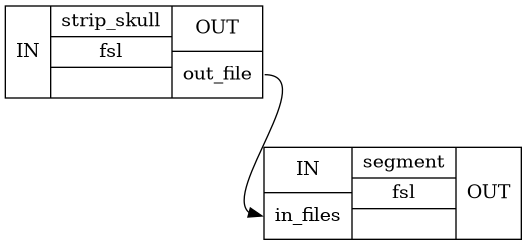

In [16]:
wf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename="output/working_dir/test_workflow/graph_detailed.png")

That looks good. As you can see on the graph above, we will first perform skullstripping and then use its output file as the input file for the segmentation. 

We are now ready to execute the workflow. This can be done by calling the ```run()``` method (note that segmentation takes about 4 minutes to run on Colab as it's a rather computional heavy procedure):

In [17]:
wf.run()

221108-14:18:08,553 nipype.workflow INFO:
	 Workflow test_workflow settings: ['check', 'execution', 'logging', 'monitoring']
221108-14:18:08,558 nipype.workflow INFO:
	 Running serially.
221108-14:18:08,559 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.strip_skull" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/strip_skull".
221108-14:18:08,564 nipype.workflow INFO:
	 [Node] Executing "strip_skull" <nipype.interfaces.fsl.preprocess.BET>
221108-14:18:10,809 nipype.workflow INFO:
	 [Node] Finished "strip_skull", elapsed time 2.243369s.
221108-14:18:10,823 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.segment" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/segment".
221108-14:18:10,827 nipype.workflow INFO:
	 [Node] Executing "segment" <nipype.interfaces.fsl.preprocess.FAST>
221108-14:22:00,180 nipype.workflow INFO:
	 [Node] Finished "segment", elapsed time 229.350933s.


Great! A few cells above, we have defined ```working_dir``` as the base directory of our workflow - here, every node has a separate subdirectory where its outputs and additional info are stored. Looking at the working directory of the segmentation node ```working_dir/test-workflow/segment``` you can see that a lot of files have been created. One way to access the node results is to load the results file stored in the directory (ending with ```.pklz```) using Nipype's ```loadpkl``` function:

In [23]:
from nipype.utils.filemanip import loadpkl

segment_results = loadpkl(
    "output/working_dir/test_workflow/segment/result_segment.pklz"
)
print(segment_results.outputs)


bias_field = <undefined>
mixeltype = /home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/segment/sub-01_T1w_brain_mixeltype.nii
partial_volume_files = ['/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/segment/sub-01_T1w_brain_pve_0.nii', '/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/segment/sub-01_T1w_brain_pve_1.nii', '/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/segment/sub-01_T1w_brain_pve_2.nii']
partial_volume_map = /home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/segment/sub-01_T1w_brain_pveseg.nii
probability_maps = <undefined>
restored_image = <undefined>
tissue_class_files = <undefined>
tissue_class_map = /home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/segment/sub-01_T1w_brain_seg.nii



Let's have a look at the three partial volume files that have been created. These files represent the tissue types that have been segmented (i.e., Grey Matter, White Matter and CSF). According to the [FSL documentation](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST) "*each voxel contains a value in the range 0-1 that represents the proportion of that class's tissue present in that voxel*".

In [ ]:
plot_labels = {0: "CSF", 1: "Grey Matter", 2: "White Matter"}

for i, label in plot_labels.items():
    plotting.plot_anat(
        f"output/working_dir/test_workflow/segment/sub-01_T1w_brain_pve_{i}.nii",
        title=label,
    )

## Exercise

In this notebook, we illustrated Nipype Nodes and Workflows only on the anatomical image. The goal of the individual assignment will be to preprocess both the functional and anatomical image so that a first level analysis can be performed. This exercise includes the first steps of the preprocessing of the functional image. The exact steps are: 

- Setup a new workflow
- Setup a node for Slicetime correction (using [```fsl.SliceTimer```](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.preprocess.html#slicetimer))
  - Use ```/data/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz``` as the input file
  - You will need the Repitition Time (TR): You can find it by inspecting either the header of the functional image (using Nibabel) or the ```task-flanker_bold.json``` file in the data directory
  - Assume interleaved slice acquisition
- Setup a node for motion correction (using [```fsl.MCFLIRT```](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.preprocess.html#mcflirt))
  - Use mean registration
  - Save transformation (motion) parameters
- Connect the nodes
- Run the workflow


### Bonus Exercise

Try investigating different brain extraction thresholds. Create an array with from 0.1 to 0.8 in steps of 0.2. Call ```BET``` within a loop to perform brain extraction for every threshold specified in the array. Finally, plot all output images

## Resources

[Nipype Tutorial on Nodes](https://miykael.github.io/nipype_tutorial/notebooks/basic_nodes.html)

[Nipype Tutorial on Workflows](https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html)



## References

Kalavathi, P., & Prasath, V. B. (2016). Methods on Skull Stripping of MRI Head Scan Images-a Review. Journal of digital imaging, 29(3), 365–379. https://doi.org/10.1007/s10278-015-9847-8